In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle

from tqdm import tqdm

from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

import colorcet as cc

In [120]:
### load signals and the model
load_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210904_aws_clustered_filters'

file = os.path.join(load_dir, 'wlk_signals.npy')
signals = np.load(file)

file = os.path.join(load_dir, 'wlk_cluster_model.pkl')
with open(file, "rb") as f:
    model = pickle.load(f)

In [32]:
os.listdir(load_dir)

['rot_to_delete.npy',
 'rot_cluster_model.pkl',
 'fwd_signals.npy',
 'wlk_signals.npy',
 'fwd_cluster_model.pkl',
 'wlk_cluster_model.pkl',
 'rot_signals.npy',
 'rot_signals_for_clustering.npy']

In [121]:
sums = np.sum(signals,axis=-1)
to_delete = np.where(sums==0)[0]
signals_for_clustering = np.delete(signals, to_delete,axis=0)
# normalize
maxs = np.max(np.abs(signals_for_clustering),axis=-1)
signals_for_clustering = signals_for_clustering/maxs[:,np.newaxis]
signals_for_clustering.shape

(82234, 40)

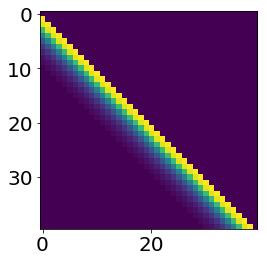

In [123]:
###########################################
### Create estimate of gcamp6f kinetics ###
###########################################

# for temporal CC I have 500 tp giving 10 sec, or 20ms timesteps
# here for aws model, I have 40 tp giving 4sec, or 100ms timesteps

def fit_eq(x, a, b, c, d, e):
    return a*(1-np.exp(-x/b))*(c*np.exp(-x/d)) + e

x = np.arange(0, 10, 1)
y = fit_eq(x, 1, 4, -1, 8/5, 0)

filter_ = y*-1
filter_padded = np.pad(filter_, (0, 30), 'constant') #wlk, rot
#filter_padded = np.pad(filter_, (0, 40), 'constant') #fwd


toe = scipy.linalg.toeplitz(filter_padded,r=[0]*40) #wlk, rot
#toe = scipy.linalg.toeplitz(filter_padded,r=[0]*50) #fwd

plt.imshow(toe)

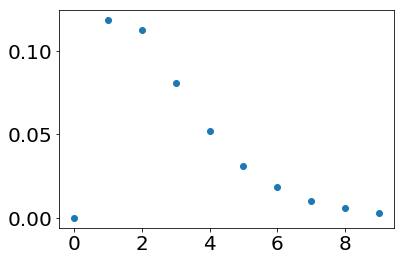

In [124]:
plt.plot(x,y*-1,'o')

In [125]:
# deconvolve
deconv = np.linalg.lstsq(toe, signals_for_clustering.T)[0]

# Remove edge artifact
deconv[:2,:] = deconv[2,:]
deconv[-2:,:] = deconv[-2,:]

# renormalize
maxs = np.max(np.abs(deconv.T),axis=-1)
signals_for_clustering = deconv.T/maxs[:,np.newaxis]
signals_for_clustering.shape

(82234, 40)

In [126]:
### Create linkage matrix for dendrogram

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

In [ ]:
#22

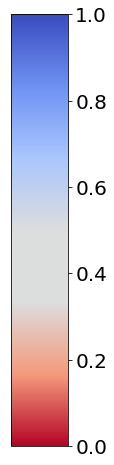

In [127]:
#wlk,rot
end = 24
start = 17
middle = 20

#fwd
# end = 24+5
# start = 17+5
# middle = 20+5

colors1 = plt.cm.coolwarm_r(np.linspace(0, .5, middle-start))
colors2 = plt.cm.coolwarm_r(np.linspace(.5, 1, end-middle))
spectral_map = mcolors.LinearSegmentedColormap.from_list('my_colormap', np.vstack((colors1, colors2)))

a = np.array([[0,1]])
plt.figure(figsize=(1, 10))
img = plt.imshow(a, cmap=spectral_map)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(cax=cax)

# plt.colorbar(cax=cax,ticks=[])
# save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
# timestr = time.strftime("%Y%m%d-%H%M%S")
# fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [128]:
###############
n_clusters = 20
###############

### Given a desired # of clusters, grab the distance threshold - needed for dendrogram
thresh = model.distances_[-n_clusters+1]

### Grab the cluster ids
cluster_ids = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

### mean cluster responses
cluster_responses = []
for n in np.unique(cluster_ids):
    cluster_response = np.mean(signals_for_clustering[cluster_ids==n,:], axis=0)
    cluster_responses.append(cluster_response)
    
### peak time of clusters (for determining color)
cluster_peak_times = []
for n in range(len(np.unique(cluster_ids))):
    clus_max = np.max(cluster_responses[n])
    clus_min = np.abs(np.min(cluster_responses[n]))
    if clus_max>clus_min:
        max_value_time = np.argmax(cluster_responses[n])
    else:
        max_value_time = np.argmin(cluster_responses[n])
    cluster_peak_times.append(max_value_time)

    
### Create the same # of colors as # of clusters
#custom_cmap = cm.jet(np.linspace(0, 1, n_clusters))
#custom_cmap = blue_gray_red_cmap(np.linspace(0, 1, n_clusters))

custom_cmap = spectral_map([(n-start)/(end-start) for n in cluster_peak_times])

cluster_colors = [mpl.colors.rgb2hex(rgb[:3]) for rgb in custom_cmap]
hierarchy.set_link_color_palette(cluster_colors)

In [129]:
n_clusters_few = 4
cluster_ids_few = fcluster(linkage_matrix, t=n_clusters_few, criterion='maxclust')

n_clusters_many = 20
cluster_ids_many = fcluster(linkage_matrix, t=n_clusters_many, criterion='maxclust')

cluster_reassignment = []
for n in range(1,n_clusters_many+1):
    cluster_reassignment.append(np.median(cluster_ids_few[np.where(cluster_ids_many==n)]))

In [49]:
cluster_reassignment

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 4.0,
 4.0,
 4.0]

In [130]:
cluster_colors_for_brain = cluster_colors[:]
#cluster_colors_for_brain.insert(0,'grey')
cmap = colors.ListedColormap(cluster_colors_for_brain)

#add_deleted_voxels = np.zeros(256*128*49) #fwd
add_deleted_voxels = np.zeros(156*73*46)

#add_deleted_voxels[:] = np.nan #<---------
to_replace = np.where(sums!=0)[0]

In [131]:
add_deleted_voxels[to_replace] = cluster_ids #model.labels_ ### put signal here
add_deleted_voxels[to_delete] = np.nan #<------
to_plot = np.reshape(add_deleted_voxels, (156,73,46))
#to_plot = np.reshape(add_deleted_voxels, (256,128,49)) #fwd

In [114]:
signals_for_clustering.shape

(125786, 50)

In [132]:
signals_for_plotting = signals_for_clustering[:,3:-2] #rot, wlk
#signals_for_plotting = signals_for_clustering[:,8:-7] #fwd

signals_for_plotting.shape

(82234, 35)

In [116]:
cluster_responses[0].shape

(50,)

In [81]:
timepoints[20]

0

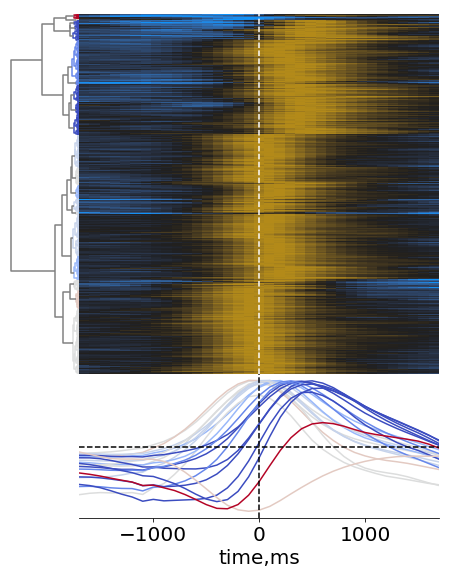

In [134]:
fig = plt.figure(figsize=(10,10))

### dendrogram ###
ax_dendrogram = fig.add_axes([1, .3, .1, .5])
ax_dendrogram.axis('off')
dend = dendrogram(linkage_matrix,
           truncate_mode=None,
           p=0,
           color_threshold=thresh,
           no_labels=True,
           distance_sort=True,
           above_threshold_color='grey',
           orientation='left');

### all resp ###
ax_dend = fig.add_axes([1.1, .3, .5, .5])
aspect = signals_for_plotting.shape[1]/signals_for_plotting.shape[0]
#cet_CET_D13_r = minty fresh
ax_dend.imshow(signals_for_plotting[dend['leaves'][::-1],:],vmin=-1,vmax=1,aspect=aspect,cmap='cet_bky')
ax_dend.axis('off')
for line in [17]:
    ax_dend.axvline(line,color='w',linestyle='--')     
#plt.title('top 25% fwd, ward, normalized')

### Mean resp ###
ax = fig.add_axes([1.1, 0.1, .5, .2])
timepoints = list(range(-2000,0,100)) + list(range(0,2000,100))

for n in range(len(np.unique(cluster_ids))):
    ax.plot(timepoints[3:-2], cluster_responses[n][3:-2],color=cluster_colors[n]) #rot, wlk
    #ax.plot(timepoints[3:-2], cluster_responses[n][8:-7],color=cluster_colors[n]) #fwd
ax.axvline(0,color='k',linestyle='--')
ax.axhline(0,color='k',linestyle='--')
ax.set_xlabel('time,ms')
ax.set_yticklabels([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.set_xlim(-2000,1900)
#ax.set_xlim(-2500,2400) old fwd
ax.set_xlim(-1700,1700)


# ### BRAIN ###
# grid = ImageGrid(fig, rect=[.3,.1,.7,.7], nrows_ncols=(8, 4), axes_pad=.05)
# for j,i in enumerate(range(8,49-9)):
#     #grid[j].imshow(out['warpedmovout'].numpy()[:,:,i].T,cmap='gray')
#     cax = grid[j].imshow(to_plot[:,:,i].T,cmap=cmap,vmin=1,vmax=n_clusters);
# for i in range(32):
#     grid[i].axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight', transparent=True)

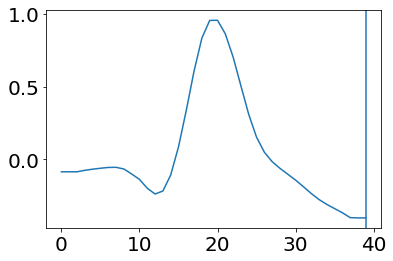

In [62]:
plt.plot(cluster_responses[0])
plt.axvline(39)

In [69]:
len(cluster_responses[0][1:-2])

37

In [59]:
a = list(range(0,10))
print(a)
a[3-2:3+2]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


[1, 2, 3, 4]

In [16]:
signals_for_clustering.shape

(125786, 50)

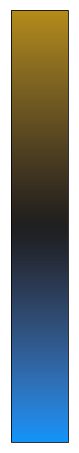

In [119]:
a = np.array([[0,1]])
plt.figure(figsize=(1, 10))
img = plt.imshow(a, cmap='cet_bky')
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(cax=cax,ticks=[])

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

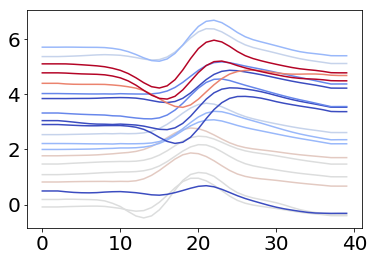

In [204]:
for c in range(len(cluster_responses)):
    plt.plot(cluster_responses[c]+c*.3,color=cluster_colors[c])

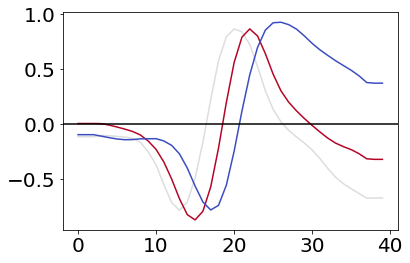

In [256]:
### FWD ###
pre = [8,9,10,11]
peri = [14,15,16,17,18,19]
post = [0,1,3,4,5,6]
bi = [2,7,12,13]
#################

### WLK ###
pre = [19]
peri = [0,1,2,3,4,5,6,7,8,9,18] # should add back 0
post = [10,11,12,13,14,15,16,17]
bi = []

### ROT ###
pre = [15,16]
peri = [0,3,4,5,6,7,8,9,18,19]
post = [2,11,12,13,14]
bi = [1,17,10]


filter_types = {}
filter_types['pre'] = pre
filter_types['peri'] = peri
filter_types['post'] = post
filter_types['bi'] = bi

for c in bi:
    plt.plot(cluster_responses[c],color=cluster_colors[c])
plt.axhline(0,color='k')

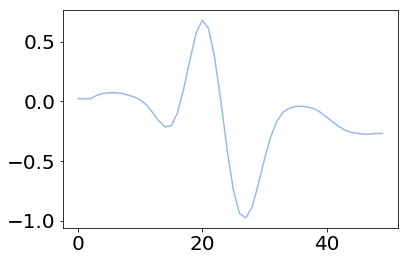

In [114]:
c=7
plt.plot(cluster_responses[c],color=cluster_colors[c])

In [25]:
cluster_peak_times

[27,
 27,
 35,
 26,
 28,
 28,
 30,
 27,
 22,
 22,
 21,
 22,
 27,
 27,
 25,
 25,
 26,
 24,
 24,
 23]

In [ ]:
### We need a way to find how these 20 clusters get assigned to 4 clusters


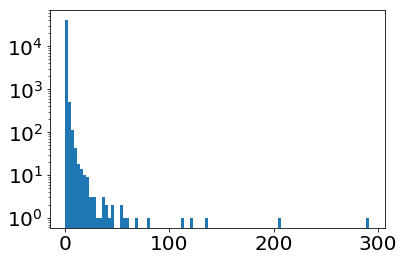

In [12]:
plt.hist(model.distances_,bins=100,log=True);

In [19]:
to_plot.shape

(156, 73, 46)

In [ ]:
# this "to_plot" has already been warped for mirroring

In [14]:
### Load Atlas ###
atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)
#atlas = ants.resample_image(atlas,(256,128,49),use_voxels=True)

(-0.5, 313.5, 145.5, -0.5)

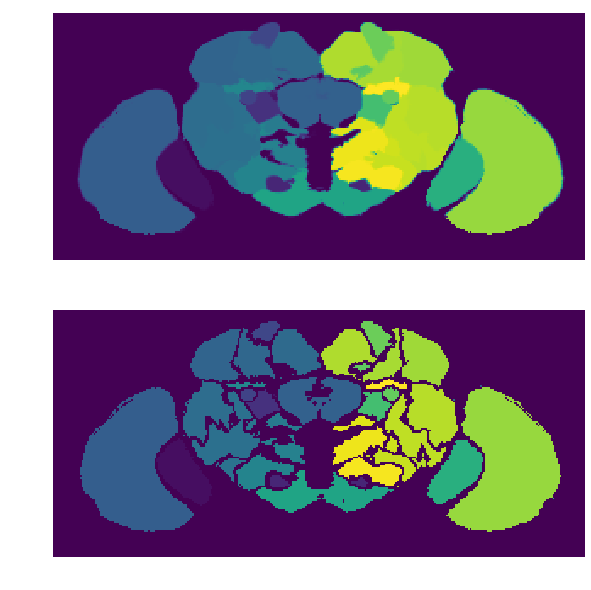

In [15]:
atlas = atlas.numpy()
atlas_int = np.rint(atlas)
atlas_clean = np.copy(atlas_int)
diff_atlas = atlas_int - atlas
thresh = 0.001
atlas_clean[np.where(np.abs(diff_atlas)>thresh)] = 0

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(atlas[:,:,50].T)
plt.axis('off')

plt.subplot(212)
plt.imshow(atlas_clean[:,:,50].T)
plt.axis('off')

In [249]:
to_plot_ants = ants.from_numpy(to_plot)
to_plot_ants = ants.resample_image(to_plot_ants,(314, 146, 91),use_voxels=True,interp_type=1)
to_plot = to_plot_ants.numpy()
to_plot.shape

(314, 146, 91)

In [16]:
####################################
### FOR SINGLE MAP (ie, not RGB) ###
####################################

def plot_grouped_roi_image(rois,plot=True):
    roi_data = []
    roi_contours = []

    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    for roi in rois:
        ####################
        ### Get roi mask ###
        ####################

        mask = np.zeros(atlas_clean.shape)
        mask[np.where(atlas_clean == roi)] = 1

        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)

        # use this for plotting clusters
#         # temporal
#         masked_roi = mask_dilated*np.nan_to_num(to_plot_new)#*temporal_map #CORR
#         #masked_roi = mask_dilated*np.nan_to_num(corr)#*temporal_map #CORR

#         masked_roi_flat = np.max(masked_roi,axis=2)
#         roi_data.append(masked_roi_flat)
        #print(np.sum())
        
        #PCA or any diverging (Turn off if above is on) <---------------
        masked_roi = mask_dilated*np.nan_to_num(corr)
        maxs = np.max(masked_roi,axis=2)
        mins = np.min(masked_roi,axis=2)
        maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
        masked_roi_flat = maxs
        roi_data.append(masked_roi_flat)
    
        #######################
        ### Get roi contour ###
        #######################
        
        _, mask_binary = cv2.threshold(np.max(mask_dilated,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas_clean[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
        roi_contours.append(roi_contour)

        # for plotting
        left_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0])
        right_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1])
        top_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0])
        bottom_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1])
        
    # get extreme edges from all rois used
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ############
    ### PLOT ###
    ############
        
    #for plotting clusters
#     roi_datas = np.max(np.asarray(roi_data),axis=0)
#     data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge],0,1)
    
    #PCA (Turn off if above is on) <---------------
    roi_data = np.asarray(roi_data)
    maxs = np.max(roi_data,axis=0)
    mins = np.min(roi_data,axis=0)
    maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
    data_map = np.swapaxes(maxs[top_edge:bottom_edge,left_edge:right_edge],0,1)

    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(data_map)

    contours_to_export = []
    for i in range(len(roi_contours)):
        single_contour = np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1)
        contours_to_export.append(single_contour)
        if plot:
            plt.imshow(single_contour)
        
    return data_map, contours_to_export

def place_on_canvas(input_canvas, to_plot, is_contour=False, is_midline=True, x_shift=0, y_shift=0):
    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)

    y_mid = int(to_plot.shape[0]/2)
    x_mid = int(to_plot.shape[1]/2)

    height = to_plot.shape[0]
    width = to_plot.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height

    if is_contour:
        ys = np.where(to_plot[:,:,0]>0)[0] + full_y_mid - y_mid + y_shift
        xs = np.where(to_plot[:,:,0]>0)[1] + full_x_mid - x_mid + x_shift
        input_canvas[ys,xs]=-1 #changed from 1 to -1 so can use set_under to pick specific color
    else:
        input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift] += to_plot #made this +=
    return input_canvas

def place_on_canvas_wrapper(canvas, data_map, contours, y_shift, x_shift):
    canvas = place_on_canvas(canvas, to_plot=data_map, y_shift=y_shift, x_shift=x_shift)
    for i in range(len(contours)):
        canvas = place_on_canvas(canvas, to_plot=contours[i], is_contour=True, y_shift=y_shift, x_shift=x_shift)
    return canvas

def wraper_wraper(canvas, roi_ids, y_shift, x_shift):
    data_map, contours = plot_grouped_roi_image(roi_ids, plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    return canvas

In [54]:
##################
### ROI GROUPS ###
##################

FB_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L'}

ventromedial_r_group = {
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R'}

ventromedial_l_group = {
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L'}

PB = {6: 'PB'}
EB = {23: 'EB'}

anterior_group = {
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L'}

big_r_group = {
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R'}
    
big_l_group = {
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L'}

In [51]:
np.unique(np.nan_to_num(to_plot))

array([0., 1., 2., 3., 4., 5., 6., 7., 8.], dtype=float32)

In [52]:
for n in range(1,9):
    print(n)

1
2
3
4
5
6
7
8


In [119]:
cmap.set_under('k')
cmap.set_bad('w')

In [39]:
cluster_reassignment

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 4.0,
 4.0,
 4.0]

In [46]:
cN = np.where(np.asarray(cluster_reassignment)==1)[0]+1

array([1, 2, 3, 4, 5, 6, 7])

In [48]:
corr = to_plot.copy()
corr[np.where((to_plot<cN[0]) | (to_plot>cN[-1]))]=np.nan

In [55]:
pre

[8, 9, 10, 11]

In [186]:
filter_types['peri']

[1, 2, 3, 4, 5, 6, 7, 8, 9, 18]

In [88]:
for n in range(20):
    if n not in filter_types['bi']:
        print(n)

0
1
3
4
5
6
8
9
10
11
14
15
16
17
18
19


In [257]:
canvi = []
for filter_type in ['pre','peri','post','bi']:
    print(filter_type)
    filter_nums = filter_types[filter_type]
    #cN = np.where(np.asarray(cluster_reassignment)==n)[0]+1
    corr = to_plot.copy()
    for n in range(20):
        if n not in filter_nums:
            corr[np.where(to_plot == n+1)] = np.nan
        else:
            print(F'keeping {n}')

    # corr = to_plot.copy()
    # corr[np.where(to_plot!=n)]=np.nan

    input_canvas = np.zeros((500,500)) #pca


    x_shift=0; y_shift=0
    data_map, contours = plot_grouped_roi_image(FB_group.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    x_shift=0; y_shift=-45
    data_map, contours = plot_grouped_roi_image(PB.keys(), plot=False)
    canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    x_shift=0; y_shift=35
    data_map, contours = plot_grouped_roi_image({23: 'EB'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    ##########
    ### MB ###
    ##########

    # x_shift=60; y_shift=-50
    # data_map, contours = plot_grouped_roi_image(MB_left_group.keys(), plot=False)
    # canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    # x_shift=-60; y_shift=-50
    # data_map, contours = plot_grouped_roi_image(MB_right_group.keys(), plot=False)
    # canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    #################
    ### BIG GROUP ###
    #################

    x_shift=-125; y_shift=30
    data_map, contours = plot_grouped_roi_image(big_r_group.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    x_shift=125; y_shift=30
    data_map, contours = plot_grouped_roi_image(big_l_group.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    ##############
    ### VISUAL ###
    ##############

    x_shift=-130; y_shift=165
    data_map, contours = plot_grouped_roi_image({25: 'MED_R'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    x_shift=130; y_shift=175
    data_map, contours = plot_grouped_roi_image({71: 'MED_L'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    x_shift=-65; y_shift=40+175
    data_map, contours = plot_grouped_roi_image({3: 'LO_R'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    x_shift=65; y_shift=40+175
    data_map, contours = plot_grouped_roi_image({53: 'LO_L'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    x_shift=-150; y_shift=210-125
    data_map, contours = plot_grouped_roi_image({22: 'LP_R'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    x_shift=150; y_shift=210-125
    data_map, contours = plot_grouped_roi_image({69: 'LP_L'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    canvas = wraper_wraper(canvas, ventromedial_r_group.keys(), y_shift=55, x_shift=-50)
    canvas = wraper_wraper(canvas, ventromedial_l_group.keys(), y_shift=55, x_shift=50)

    canvas = wraper_wraper(canvas, anterior_group.keys(), y_shift=140, x_shift=0)

    canvas = wraper_wraper(canvas, {34: 'AOTU_R'}.keys(), y_shift=-50+175-25, x_shift=-80)
    canvas = wraper_wraper(canvas, {79: 'AOTU_L'}.keys(), y_shift=-50+175-25, x_shift=80)

    canvas[np.where(canvas==0)] = np.nan ### these will be set to white
    canvi.append(canvas)

    # plt.figure(figsize=(10,10))
    # plt.imshow(canvas[150:,:],cmap=cmap,vmin=1,vmax=n_clusters)
    # plt.axis('off')

    #     save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
    #     timestr = time.strftime("%Y%m%d-%H%M%S")
    #     fname = os.path.join(save_path, f'{timestr}_wlk')
    #     #plt.savefig(fname,dpi=300,bbox_inches='tight')

pre
keeping 15
keeping 16
peri
keeping 0
keeping 3
keeping 4
keeping 5
keeping 6
keeping 7
keeping 8
keeping 9
keeping 18
keeping 19
post
keeping 2
keeping 11
keeping 12
keeping 13
keeping 14
bi
keeping 1
keeping 10
keeping 17


In [78]:
n_clusters

20

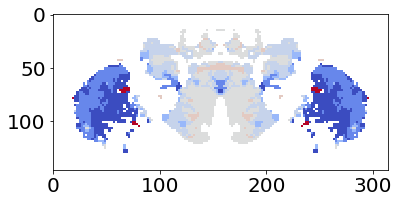

In [191]:
plt.imshow(to_plot[:,:,50].T,cmap=cmap,vmin=1,vmax=n_clusters)

In [107]:
np.max(np.nan_to_num(np.unique(to_plot)))

20.0

(-0.5, 499.5, 349.5, -0.5)

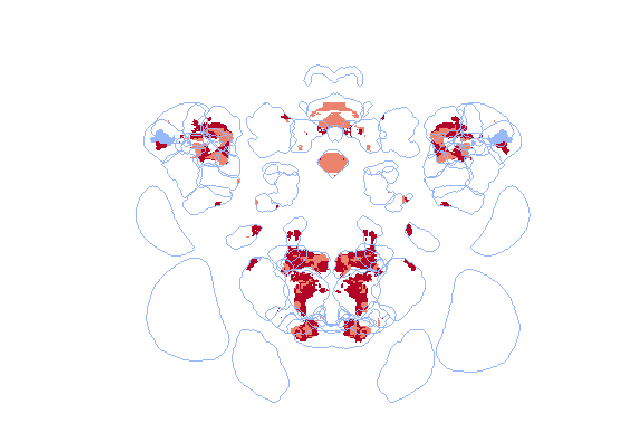

In [86]:
plt.figure(figsize=(10,10))
plt.imshow(canvi[0][150:,:],cmap=cmap,vmin=1,vmax=n_clusters)
plt.axis('off')

In [60]:
cmap.set_under('k')
cmap.set_bad('w')

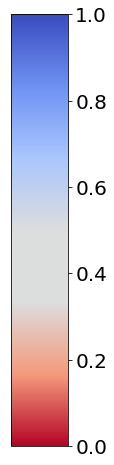

In [161]:
end = 24
start = 17
middle = 20

colors1 = plt.cm.coolwarm_r(np.linspace(0, .5, middle-start))
colors2 = plt.cm.coolwarm_r(np.linspace(.5, 1, end-middle))
spectral_map = mcolors.LinearSegmentedColormap.from_list('my_colormap', np.vstack((colors1, colors2)))

custom_cmap = spectral_map([(n-start)/(end-start) for n in cluster_peak_times])
cluster_colors = [mpl.colors.rgb2hex(rgb[:3]) for rgb in custom_cmap]
cluster_colors_for_brain = cluster_colors[:]
cmap = colors.ListedColormap(cluster_colors_for_brain)

a = np.array([[0,1]])
plt.figure(figsize=(1, 10))
img = plt.imshow(a, cmap=spectral_map)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(cax=cax)

cmap.set_under('k')
cmap.set_bad('w')

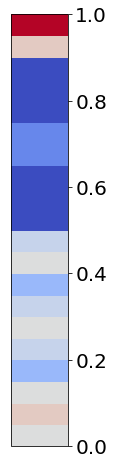

In [182]:
a = np.array([[0,1]])
plt.figure(figsize=(1, 10))
img = plt.imshow(a, cmap=cmap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(cax=cax)

In [183]:
filter_types['pre']

[19]

In [252]:
cmap.set_under('k')
cmap.set_bad('w')

In [147]:
### Special case - make fwd accel cluster black so it can be distinguished ###
canvi[3][np.where(canvi[3]==8)] = -1

In [180]:
canvi[1][np.where(canvi[1]==0)] = np.nan

In [164]:
### how does my coloring work?
# something is getting set to black that shouldn't be
# numbers less than 0 get set to black
# for some reason my filter=0 was getting set to black for wlk

20

In [185]:
cluster_colors[0]

'#dcdddd'

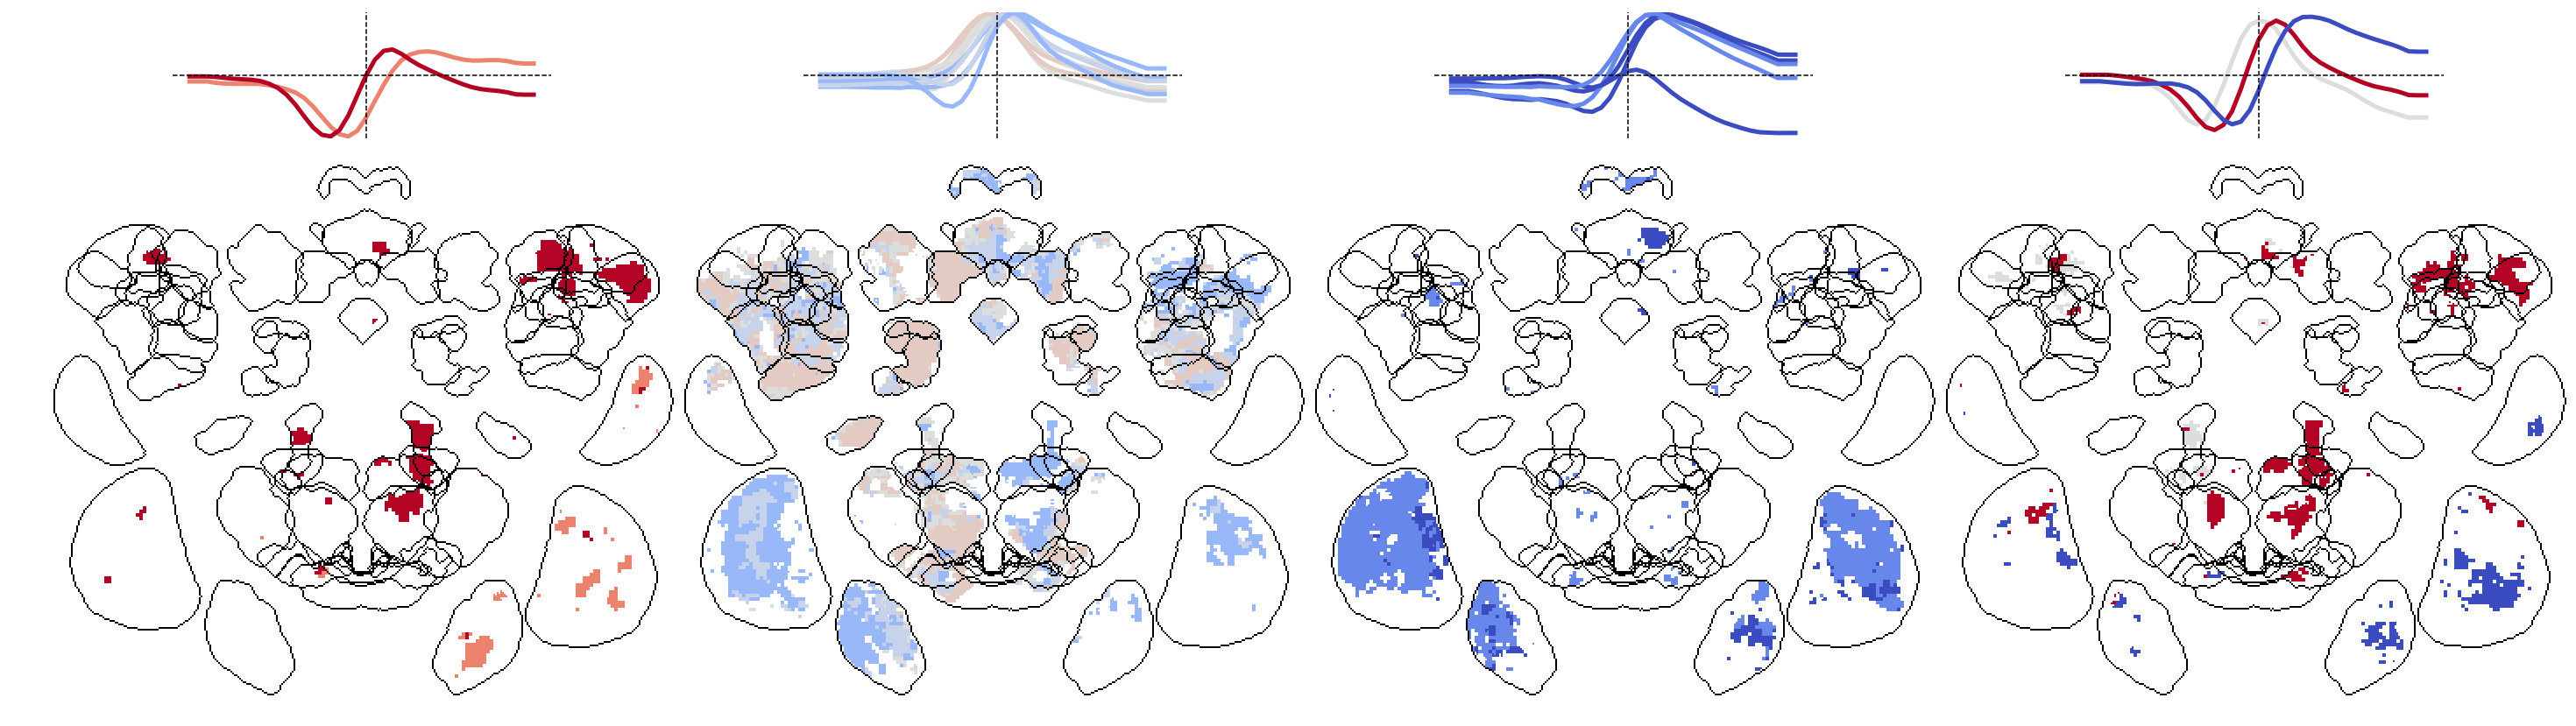

In [259]:
fig = plt.figure(figsize=(10,10))
for k, filter_type in enumerate(['pre','peri','post','bi']):
    #plt.subplot(1,8,n)
    ax = fig.add_axes([0+k, 0, 1, 1])
    ax.imshow(canvi[k][150:,70:-70],cmap=cmap,vmin=1,vmax=n_clusters)
    ax.axis('off')
#plt.subplots_adjust(wspace=0,hspace=0)

for k, filter_type in enumerate(['pre','peri','post','bi']):
    ax = fig.add_axes([.2+k, .9, .6, .2])
    #cN = np.where(np.asarray(cluster_reassignment)==n)[0]+1
    for c in filter_types[filter_type]:
#         if c == 7: # special case to force fwd accel cluster black
#             ax.plot(timepoints, cluster_responses[c],color='k',lw=5)
#         else:
        ax.plot(timepoints, cluster_responses[c],color=cluster_colors[c],lw=5)
    ax.axvline(0,color='k',linestyle='--')
    ax.axhline(0,color='k',linestyle='--')
    ax.axis('off')
    ax.set_ylim(-1,1)
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [155]:
np.unique(np.nan_to_num(canvi[0]))

array([-1.,  0., 20.])

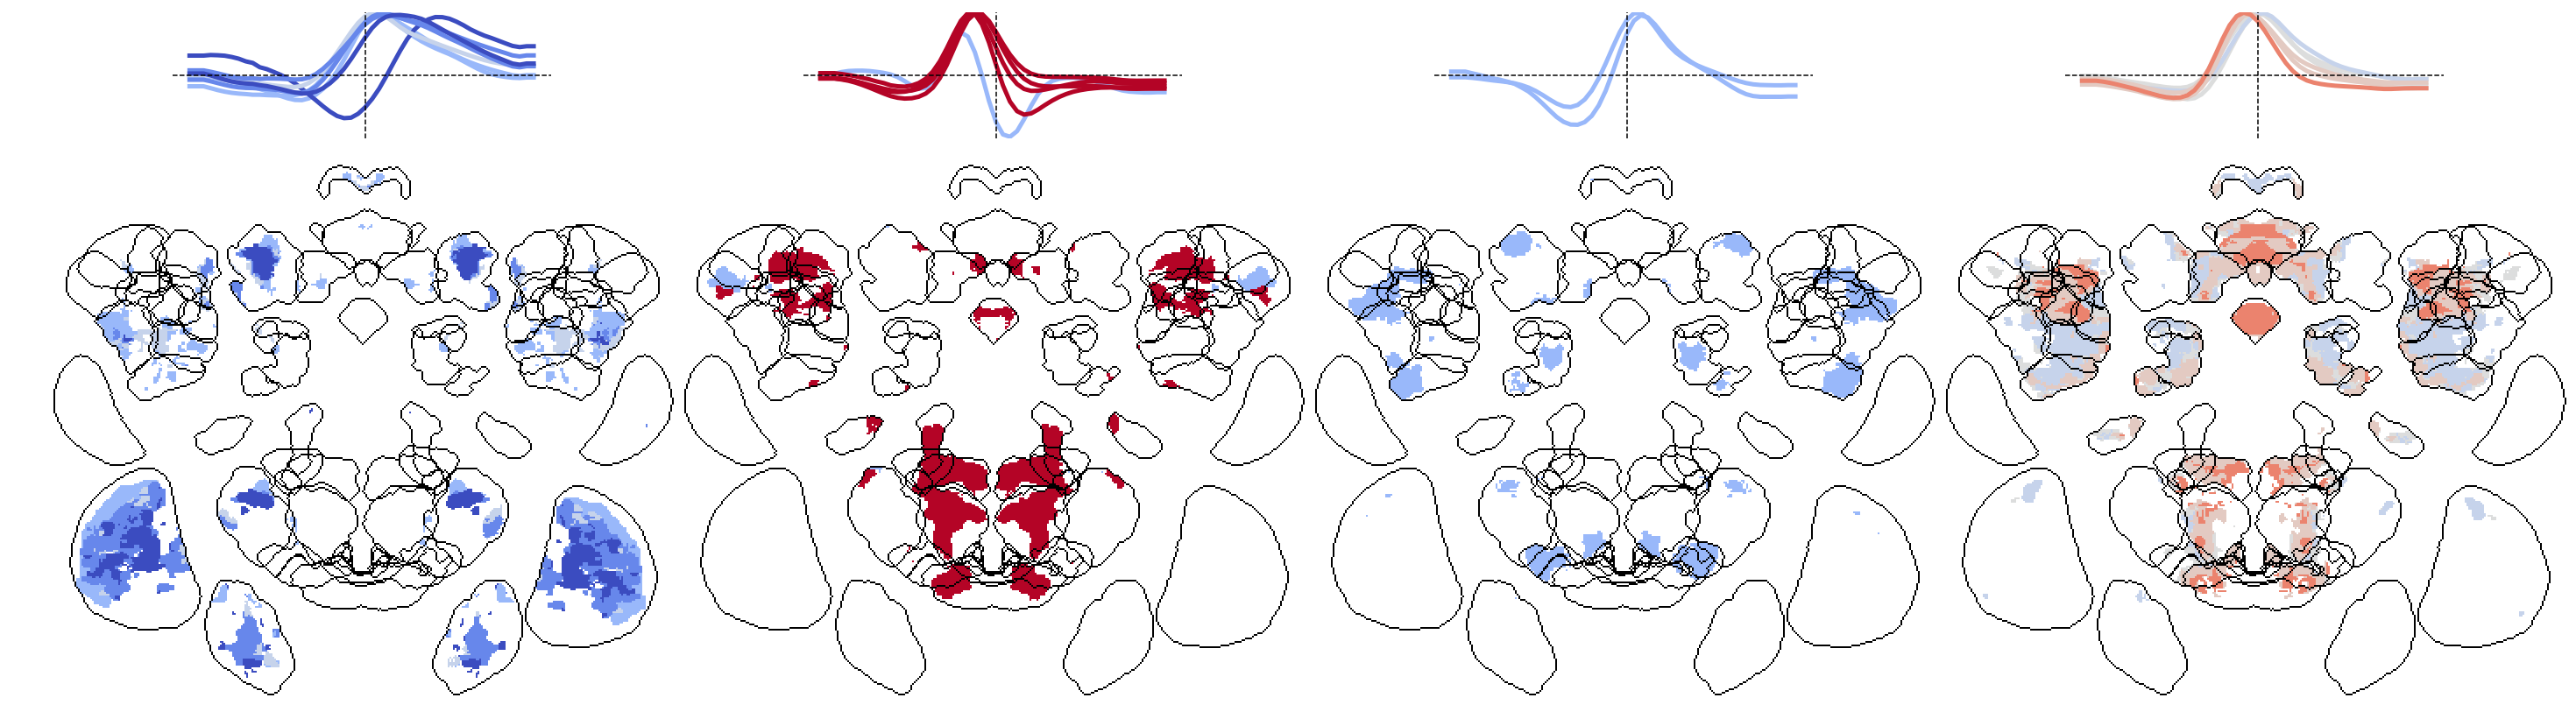

In [141]:
fig = plt.figure(figsize=(10,10))
for n in range(1,5):
    #plt.subplot(1,8,n)
    ax = fig.add_axes([0+n, 0, 1, 1])
    ax.imshow(canvi[n-1][150:,70:-70],cmap=cmap,vmin=1,vmax=n_clusters)
    ax.axis('off')
#plt.subplots_adjust(wspace=0,hspace=0)

for n in range(1,5):
    ax = fig.add_axes([.2+n, .9, .6, .2])
    cN = np.where(np.asarray(cluster_reassignment)==n)[0]+1
    for c in cN:
        ax.plot(timepoints, cluster_responses[c-1],color=cluster_colors[c-1],lw=5)
    ax.axvline(0,color='k',linestyle='--')
    ax.axhline(0,color='k',linestyle='--')
    ax.axis('off')
    ax.set_ylim(-1,1)
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

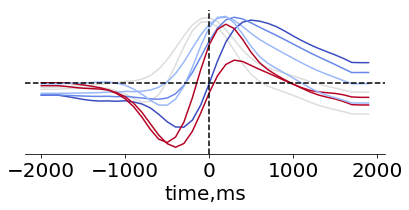

In [82]:
### Mean resp ###
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([1.1, 0.1, .5, .2])
timepoints = list(range(-2000,0,100)) + list(range(0,2000,100))
#timepoints = list(range(-2500,0,100)) + list(range(0,2500,100))

for n in range(len(np.unique(cluster_ids))):
    ax.plot(timepoints, cluster_responses[n],color=cluster_colors[n])
ax.axvline(0,color='k',linestyle='--')
ax.axhline(0,color='k',linestyle='--')
ax.set_xlabel('time,ms')
ax.set_yticklabels([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

In [60]:
cluster_responses[0].shape

(40,)

(-0.5, 499.5, 349.5, -0.5)

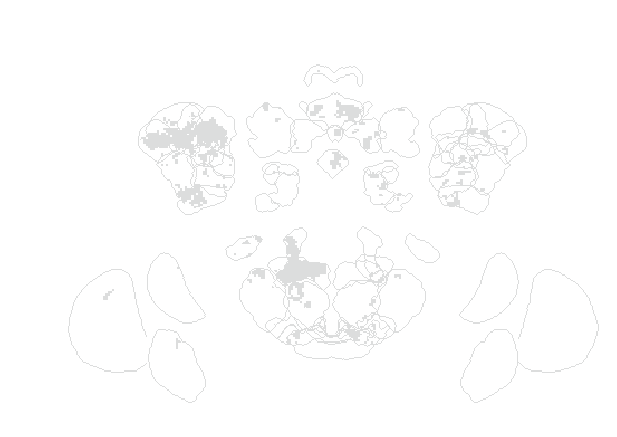

In [41]:
plt.figure(figsize=(10,10))
plt.imshow(canvas[150:,:],cmap=cmap,vmin=1,vmax=n_clusters)
plt.axis('off')

In [39]:
import glob

In [48]:
pattern = '*.ipynb'
query = '20210707-034306'
query = '20210707-034306_fwd_inv_warp'

for filepath in glob.iglob(pattern, recursive=True):
    with open(filepath) as file:
        s = file.read()
        if (s.find(query) > -1):
            print(filepath)

20210713 - aws nn filters mirror cleaning and clustering - fwd and wlk.ipynb
20210721 - AWS Filters Clustering - Rot.ipynb


In [40]:
os.listdir('.')

['20200807 - Closer look at within-fly single anat vol alignment.ipynb',
 '20200130 - onset offset walking explore baseline options.ipynb',
 'Anatomy alignment-Dec28th.ipynb',
 '20200531 - super voxels cluster outlines fig.ipynb',
 '20200524 - super voxels.ipynb',
 '20210722 - cutting rois into groups.ipynb',
 '20210216 - view results insta unique glms single reconstructed.ipynb',
 '20201207 - Bootstrap maps.ipynb',
 '20210515 - prep_data_for_aws-Copy1.ipynb',
 '20210729 - voxel corr types per atlas roi.ipynb',
 '20191208 - Inspect CMTK individual warp (including mirror) to meanbrain20191206.ipynb',
 '20200612 - super voxel full brain summary figures.ipynb',
 '20190805 - Exploring Behavior Triggers.ipynb',
 '20210601 - temporal filter normalized by autocorr for steve.ipynb',
 '20191223 - clustered_UMAP(2D)_with_behavior_video.ipynb',
 '20201207 - Bootstrap maps (backup).ipynb',
 '20201229 - Figures of single anat alignment quality.ipynb',
 '20210511 - temporal glm to fit filters.ipynb'